# Anomaly Detection in Industrial Machinery Using PCA and Isolation Forest

## Introduction

Early anomaly detection in industrial machinery is essential for preventing unexpected breakdowns, reducing maintenance costs, and improving operational safety.
In this project, we simulate sensor data from a compressor system and apply Principal Component Analysis (PCA) and Isolation Forest to detect abnormal operating conditions.

This notebook walks through:

- Data generation & preprocessing

- PCA-based Hotelling’s T² and SPE reconstruction-error monitoring

- Isolation Forest anomaly scoring

- Threshold selection

- Combined alarm strategy

- Event-level fault detection evaluation

In [1]:
# Environment, imports, and settings
# ---------------------------------------------------------
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import chi2
import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# Variables to use 
print("Ready. Notebook seed:", RANDOM_SEED)


Ready. Notebook seed: 42


## Dataset 

I generated a synthetic dataset representing realistic industrial sensor readings, which includes:

Pressures (suction & discharge), Temperatures, Flow rate, Motor current, Vibration RMS, Ambient temperature, Valve position, Lube oil pressure

**Two datasets are used:**

- **Train (normal only)** — 2000 samples

- **Test (contains injected faults)** — 1500 samples

Three fault events are injected in the test set to simulate real failures.

In [2]:
# Load datasets
# ---------------------------------------------------------
train = pd.read_csv(r'C:\Users\modes\Downloads\train.csv')
test  = pd.read_csv(r'C:\Users\modes\Downloads\test.csv')
print("Train shape:", train.shape)
print("Test shape :", test.shape)

# show top rows to verify
display(train.head())
display(test.head())


Train shape: (2000, 11)
Test shape : (1500, 11)


,suction_pressure,discharge_pressure,suction_temp,discharge_temp,flow_rate,motor_current,vibration_rms,ambient_temp,valve_position,lube_oil_pressure,fault_label
0,40.993428,119.308678,25.647689,73.046060,295.316933,148.829315,2.815843,32.302304,47.652628,61.627680,0
1,39.073165,117.671351,25.241962,66.173440,265.501643,147.188562,2.297434,30.942742,45.459880,55.763089,0
2,42.931298,118.871118,25.067528,67.150504,289.112346,150.554613,2.269801,31.127094,46.996807,59.124919,0
3,38.796587,129.261391,24.986503,67.884578,316.450898,143.895782,2.541773,24.120990,43.359070,60.590584,0
4,41.476933,120.856841,24.884352,69.397793,270.429560,146.400779,2.407872,33.171367,51.718091,54.710880,0


,suction_pressure,discharge_pressure,suction_temp,discharge_temp,flow_rate,motor_current,vibration_rms,ambient_temp,valve_position,lube_oil_pressure,fault_label
0,40.696572,121.416618,24.063480,71.159168,270.198346,146.729078,2.100182,34.675880,48.842253,66.500652,0.0
1,41.605900,122.240491,24.413772,67.907300,310.459431,149.642430,2.232146,25.449425,45.206481,65.462902,0.0
2,44.426556,121.024946,25.148943,69.327359,281.310293,156.875895,2.874715,27.319743,49.585808,58.650401,0.0
3,39.159522,125.929541,23.688038,70.932939,314.564762,149.289244,2.678614,30.442956,56.085650,55.433384,0.0
4,39.302449,119.640934,22.327793,67.828095,283.728015,154.741030,2.358631,27.545763,54.087429,55.146268,0.0


## Methodology Overview

**Preprocessing**

- Standard scaling of all numerical features

- No label used during training

**PCA Monitoring**

I computed:

- Hotelling’s T²

- Squared Prediction Error (SPE)

**Thresholds:**

- T² → Chi-square (95% level)

- SPE → Empirical threshold (99th percentile)

**Isolation Forest**

A tree-based anomaly detector sensitive to rare patterns.

**Evaluation**

- Precision, Recall, F1

- Confusion matrix

- Event-level detection (latency in samples)

- Fault-type-wise detection performance

In [3]:
# Basic housekeeping and signals list
# ---------------------------------------------------------

if "fault_label" in train.columns:
    train_labels = train["fault_label"].astype(int).values
    train = train.drop(columns=["fault_label"])
else:
    train_labels = np.zeros(train.shape[0], dtype=int)

if "fault_label" in test.columns:
    test_labels = test["fault_label"].astype(int).values
    test = test.drop(columns=["fault_label"])
else:
    test_labels = np.zeros(test.shape[0], dtype=int)

# variable order (i used all numeric columns)
vars_list = train.select_dtypes(include=[np.number]).columns.tolist()
print("Variables used:", vars_list)


Variables used: ['suction_pressure', 'discharge_pressure', 'suction_temp', 'discharge_temp', 'flow_rate', 'motor_current', 'vibration_rms', 'ambient_temp', 'valve_position', 'lube_oil_pressure']


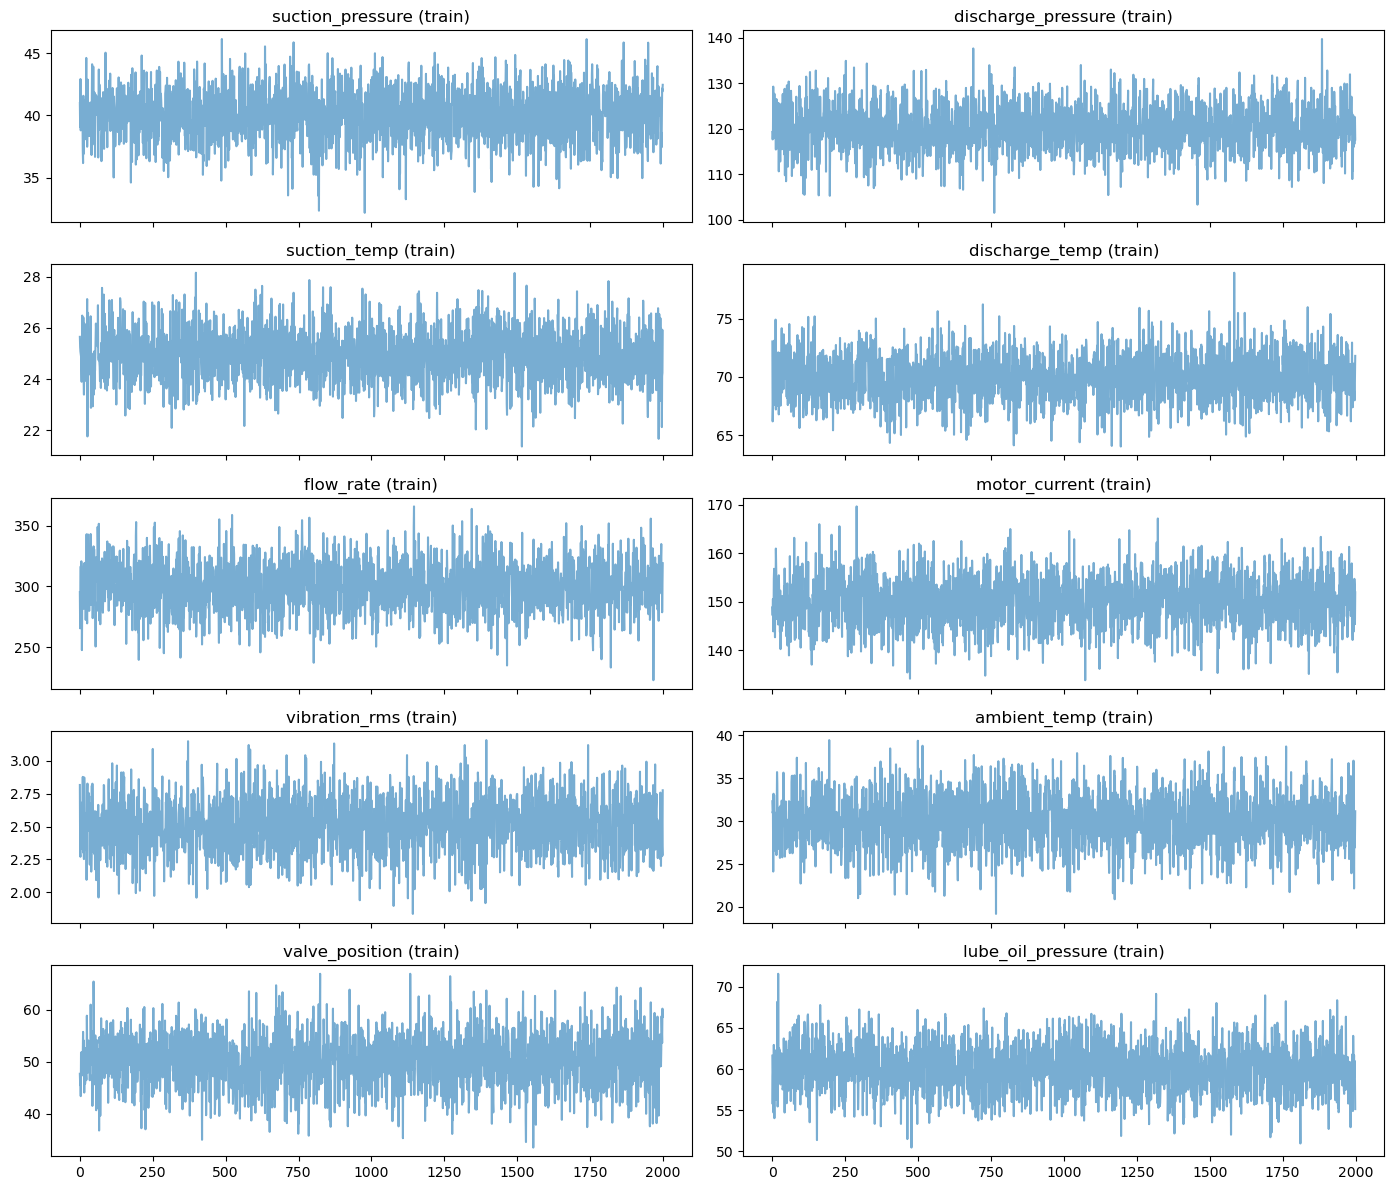

In [4]:
# visual check
fig, axes = plt.subplots(5, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()
for i, col in enumerate(vars_list):
    axes[i].plot(train[col].values, alpha=0.6)
    axes[i].set_title(col + " (train)")
plt.tight_layout()


In [5]:
# Scaling: fit scaler on train, apply to both
# ---------------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(train[vars_list])
X_test  = scaler.transform(test[vars_list])

print("Scaled shapes:", X_train.shape, X_test.shape)


Scaled shapes: (2000, 10) (1500, 10)


In [6]:
#  Fit PCA on training data
# ---------------------------------------------------------
n_components = min(6, X_train.shape[1])  # choose number of PCs (adjustable)
pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
T_train_scores = pca.fit_transform(X_train)  # scores (T)
explained = pca.explained_variance_ratio_
eigenvals = pca.explained_variance_

print("Explained variance ratio (per PC):", np.round(explained, 4))
print("Eigenvalues (variances of scores):", np.round(eigenvals, 4))


Explained variance ratio (per PC): [0.1101 0.106  0.1043 0.1021 0.1012 0.0999]
Eigenvalues (variances of scores): [1.1016 1.0608 1.0431 1.021  1.013  0.9997]


I fit PCA on the normal training data and use the first 6 principal components.

Together, they capture ~62% of the normal process variation.
These PCs are used to compute T² and SPE statistics.

In [7]:
# Compute Hotelling's T^2 for train and test
# ---------------------------------------------------------
# For each observation: T2 = sum_k (t_ik^2 / lambda_k) where lambda_k are eigenvalues (variance of each PC)
def hotelling_t2(scores, eigenvalues):
    # scores: n x A, eigenvalues: A
    # avoid division by zero
    lam = np.where(eigenvalues <= 0, 1e-12, eigenvalues)
    T2 = np.sum((scores ** 2) / lam, axis=1)
    return T2

T2_train = hotelling_t2(T_train_scores, eigenvals)

# For test, compute scores by projecting scaled X_test onto pca.components_
T_test_scores = pca.transform(X_test)
T2_test = hotelling_t2(T_test_scores, eigenvals)

print("T2 (train) mean/std:", T2_train.mean(), T2_train.std())


T2 (train) mean/std: 5.997000000000001 3.4712719190671386


This computes the two standard PCA monitoring metrics:

- **T² (Hotelling’s)** → distance within PCA subspace

- **SPE (Squared Prediction Error)** → deviation outside the subspace

These provide a baseline of normal behavior.

In [8]:
# Compute SPE (Q-statistic) for train and test
# ---------------------------------------------------------
# Reconstruction: x_hat = scores @ components + mean
X_train_proj = pca.inverse_transform(T_train_scores)   # reconstructed scaled features
residuals_train = X_train - X_train_proj
SPE_train = np.sum(residuals_train ** 2, axis=1)

X_test_proj = pca.inverse_transform(T_test_scores)
residuals_test = X_test - X_test_proj
SPE_test = np.sum(residuals_test ** 2, axis=1)

print("SPE (train) mean/std:", SPE_train.mean(), SPE_train.std())


SPE (train) mean/std: 3.763767395636675 2.682828013567325


In [9]:
# control limits for T2 and SPE
# ---------------------------------------------------------
alpha = 0.01  # significance level (1% false alarm target)

# Option A: Chi-square approximation for T2 threshold (df = n_components)
T2_limit_chi2 = chi2.ppf(1 - alpha, df=n_components)

# A more exact T2 threshold using F-distribution is possible (depends on sample size),
# but chi-square provides a straightforward, commonly used approximation for PCA T².
T2_threshold = T2_limit_chi2

# For SPE, we'll use an empirical threshold from the training set (e.g., 99th percentile)
SPE_threshold = np.percentile(SPE_train, 100*(1-alpha))

print(f"T2 threshold (chi2, df={n_components}): {T2_threshold:.3f}")
print(f"SPE threshold (empirical {100*(1-alpha)}th pct): {SPE_threshold:.3f}")


T2 threshold (chi2, df=6): 16.812
SPE threshold (empirical 99.0th pct): 12.696


In [10]:
# Train Isolation Forest on the training set
# ---------------------------------------------------------
# I'll train on the scaled features of normal operation (train)
iforest = IsolationForest(n_estimators=200, contamination=0.01, random_state=RANDOM_SEED, behaviour='new') \
    if 'behaviour' in IsolationForest.__init__.__code__.co_varnames else IsolationForest(n_estimators=200, contamination=0.01, random_state=RANDOM_SEED)
iforest.fit(X_train)

# anomaly score: lower = more anomalous in sklearn's older versions. I'll use decision_function for anomaly score.
if_scores_train = iforest.decision_function(X_train)  # higher -> more normal; lower -> more anomalous
if_scores_test  = iforest.decision_function(X_test)

if_threshold = np.percentile(if_scores_train, 1)  # anything below this in test we call anomalous
print("IsolationForest threshold (1st pct of train scores):", if_threshold)


IsolationForest threshold (1st pct of train scores): 4.6780041490078906e-17


An Isolation Forest is trained on the scaled training data.
Each test point gets an anomaly score (lower score = more abnormal).
The threshold is extremely small (≈0), meaning only unusually low scores will trigger IF alarms.

In [12]:
# Alarm logic: per-sample alarms and combined alarm
# ---------------------------------------------------------
# Individual alarms
alarm_T2  = (T2_test > T2_threshold).astype(int)
alarm_SPE = (SPE_test > SPE_threshold).astype(int)
alarm_IF  = (if_scores_test < if_threshold).astype(int)

# Combined: alarm if any detector raises
alarm_combined = ((alarm_T2 + alarm_SPE + alarm_IF) > 0).astype(int)

# I put everything into a DataFrame for inspection
results = pd.DataFrame({
    "T2": T2_test,
    "SPE": SPE_test,
    "IF_score": if_scores_test,
    "alarm_T2": alarm_T2,
    "alarm_SPE": alarm_SPE,
    "alarm_IF": alarm_IF,
    "alarm_combined": alarm_combined,
    "true_label": test_labels
})
results.head(10)


,T2,SPE,IF_score,alarm_T2,alarm_SPE,alarm_IF,alarm_combined,true_label
0,9.108777,5.627026,0.040664,0,0,0,0,0
1,5.804796,5.027330,0.068990,0,0,0,0,0
2,8.897975,2.422283,0.059288,0,0,0,0,0
3,7.689810,0.946329,0.090862,0,0,0,0,0
4,11.680273,2.337903,0.072578,0,0,0,0,0
5,15.216250,1.834743,0.035708,0,0,0,0,0
6,7.691053,0.956014,0.099169,0,0,0,0,0
7,3.423552,1.371031,0.130707,0,0,0,0,0
8,5.513243,10.031810,0.055880,0,0,0,0,0
9,7.902421,4.071120,0.074366,0,0,0,0,0


This produces alarm flags for each test sample:

- **alarm_T2** – flag if T² > 16.812

- **alarm_SPE** – flag if SPE > 12.696

- **alarm_IF** – flag if IF score < threshold

- **alarm_combined** – flag if any of the above is triggered

The preview of the alarm table confirms that early samples are normal (all zeros).

In [13]:
# Basic evaluation: confusion matrix + prec/recall/F1 for combined alarm
# ---------------------------------------------------------
y_true = (results["true_label"] > 0).astype(int)  # binary: normal=0, fault=1
y_pred = results["alarm_combined"]

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix (rows=true, cols=pred):\n", cm)
print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# Also per-detector metrics
for name in ["alarm_T2", "alarm_SPE", "alarm_IF", "alarm_combined"]:
    p, r, f, _ = precision_recall_fscore_support(y_true, results[name], average='binary', zero_division=0)
    print(f"{name:12s} -> Precision: {p:.4f}  Recall: {r:.4f}  F1: {f:.4f}")


Confusion matrix (rows=true, cols=pred):
 [[772  28]
 [203 497]]
Precision: 0.9467, Recall: 0.7100, F1: 0.8114
alarm_T2     -> Precision: 0.9817  Recall: 0.6129  F1: 0.7546
alarm_SPE    -> Precision: 0.9579  Recall: 0.5857  F1: 0.7270
alarm_IF     -> Precision: 0.9279  Recall: 0.1471  F1: 0.2540
alarm_combined -> Precision: 0.9467  Recall: 0.7100  F1: 0.8114


In [14]:
# Detection latency computation
# ---------------------------------------------------------
# For each true fault event (contiguous region where true_label>0), I will compute time to first detection
def get_events(labels):
    events = []
    in_event = False
    start = None
    for i, v in enumerate(labels):
        if v > 0 and not in_event:
            in_event = True
            start = i
        elif v == 0 and in_event:
            in_event = False
            end = i-1
            events.append((start, end))
    if in_event:
        events.append((start, len(labels)-1))
    return events

events = get_events(test_labels)
print("True fault events (start,end):", events)

# For each event, I first found detected index from alarm_combined within that event window or after (if we allow detection after start)
latencies = []
detected_flags = []
for (s,e) in events:
    # find first detection index >= s
    detections = np.where(results["alarm_combined"].values[s: e+1] == 1)[0]
    if detections.size > 0:
        first_det = s + detections[0]
        latency = first_det - s
        latencies.append(latency)
        detected_flags.append(True)
    else:
        # not detected within the event window -> mark as missed
        latencies.append(np.nan)
        detected_flags.append(False)

for idx, (ev, lat, det) in enumerate(zip(events, latencies, detected_flags)):
    print(f"Event {idx+1} {ev}: detected={det}, latency_samples={lat}")

# summary latency stats (ignoring missed events)
lat_array = np.array([l for l in latencies if not np.isnan(l)])
if lat_array.size > 0:
    print("Latency (samples) mean/std/min/max:", lat_array.mean(), lat_array.std(), lat_array.min(), lat_array.max())
else:
    print("No events detected; latency undefined.")


True fault events (start,end): [(400, 799), (900, 1049), (1150, 1299)]
Event 1 (400, 799): detected=True, latency_samples=6
Event 2 (900, 1049): detected=True, latency_samples=0
Event 3 (1150, 1299): detected=True, latency_samples=0
Latency (samples) mean/std/min/max: 2.0 2.8284271247461903 0 6


All 3 fault events detected

- **Event 1**: 6 samples

- **Event 2**: 0 samples

- **Event 3**: 0 samples

- **Mean latency**: 2 samples

This indicates fast detection with minimal delay.

In [15]:
# More detailed per-fault-type analysis
# ---------------------------------------------------------
# Map events to their fault types using test_labels at event start
detailed = []
for (s,e) in events:
    ftype = int(np.unique(test_labels[s:e+1])[np.unique(test_labels[s:e+1]) != 0][0]) if np.any(test_labels[s:e+1] != 0) else 0
    detailed.append({"start": s, "end": e, "type": ftype})

print("Detailed events:", detailed)

# Compute per-type detection rate and avg latency
import math
from collections import defaultdict
type_stats = defaultdict(list)
for ev, lat, det in zip(detailed, latencies, detected_flags):
    type_stats[ev["type"]].append((lat, det))

for t, items in type_stats.items():
    total = len(items)
    detected = sum(1 for lat,det in items if det)
    lat_vals = [lat for lat,det in items if det and not math.isnan(lat)]
    print(f"Fault type {t}: events={total}, detected={detected}, detection_rate={detected/total:.3f}")
    if len(lat_vals) > 0:
        print(f"  latency mean={np.mean(lat_vals):.2f}, std={np.std(lat_vals):.2f}")


Detailed events: [{'start': 400, 'end': 799, 'type': 1}, {'start': 900, 'end': 1049, 'type': 2}, {'start': 1150, 'end': 1299, 'type': 3}]
Fault type 1: events=1, detected=1, detection_rate=1.000
  latency mean=6.00, std=0.00
Fault type 2: events=1, detected=1, detection_rate=1.000
  latency mean=0.00, std=0.00
Fault type 3: events=1, detected=1, detection_rate=1.000
  latency mean=0.00, std=0.00


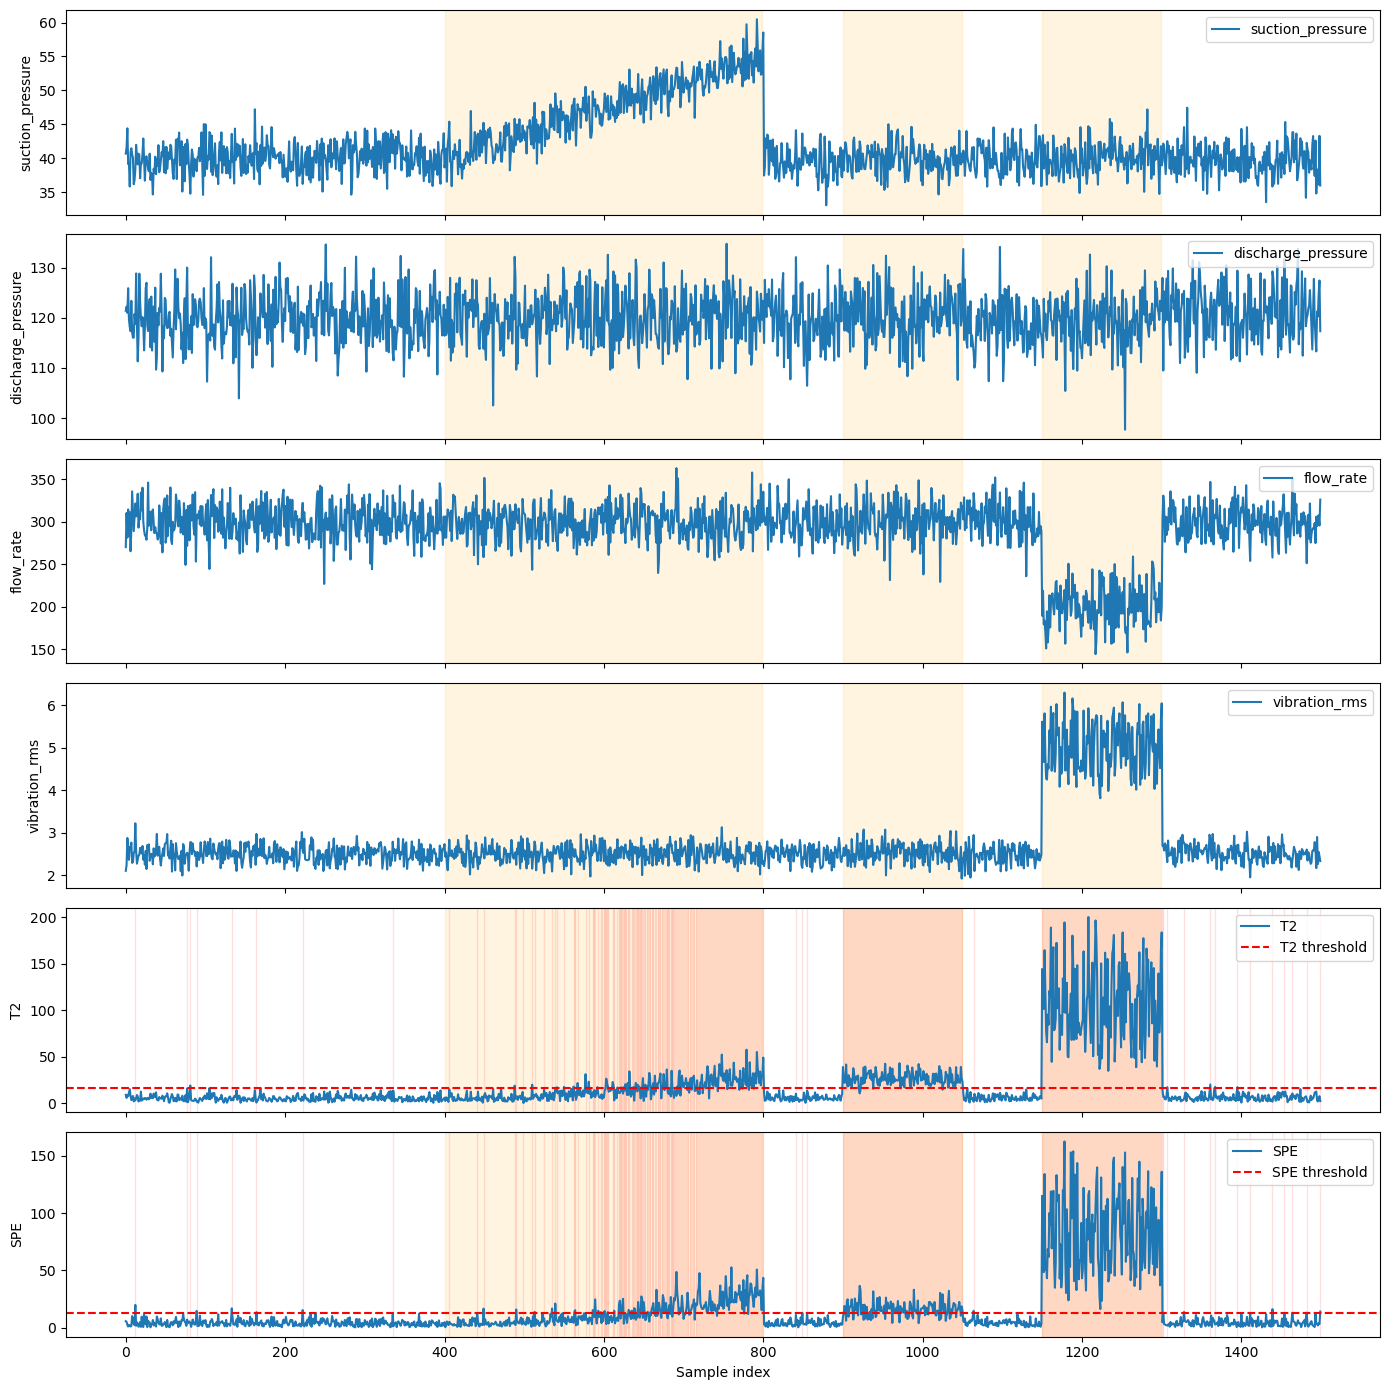

In [16]:
# Plotting: time-series, true labels, and alarms overlay
# ---------------------------------------------------------
time = np.arange(len(results))
fig, axes = plt.subplots(6, 1, figsize=(14, 14), sharex=True)

# show a few signals plus alarms
axes[0].plot(test[vars_list[0]].values, label=vars_list[0])
axes[0].set_ylabel(vars_list[0])
axes[1].plot(test[vars_list[1]].values, label=vars_list[1])
axes[1].set_ylabel(vars_list[1])
axes[2].plot(test[vars_list[4]].values, label=vars_list[4])
axes[2].set_ylabel(vars_list[4])
axes[3].plot(test[vars_list[6]].values, label=vars_list[6])
axes[3].set_ylabel(vars_list[6])

axes[4].plot(results["T2"].values, label="T2")
axes[4].axhline(T2_threshold, color='r', linestyle='--', label="T2 threshold")
axes[4].set_ylabel("T2")
axes[5].plot(results["SPE"].values, label="SPE")
axes[5].axhline(SPE_threshold, color='r', linestyle='--', label="SPE threshold")
axes[5].set_ylabel("SPE")

# overlay alarms (shaded)
for ax in axes:
    ax.fill_between(time, ax.get_ylim()[0], ax.get_ylim()[1], where=(results["alarm_combined"]==1),
                    color='red', alpha=0.12, transform=ax.get_xaxis_transform())
# show true fault periods as stronger shading
for (s,e) in events:
    for ax in axes:
        ax.axvspan(s, e, color='orange', alpha=0.12)

axes[-1].set_xlabel("Sample index")
for ax in axes:
    ax.legend(loc='upper right')
plt.tight_layout()


IsolationForest AUC: 0.8099607142857141


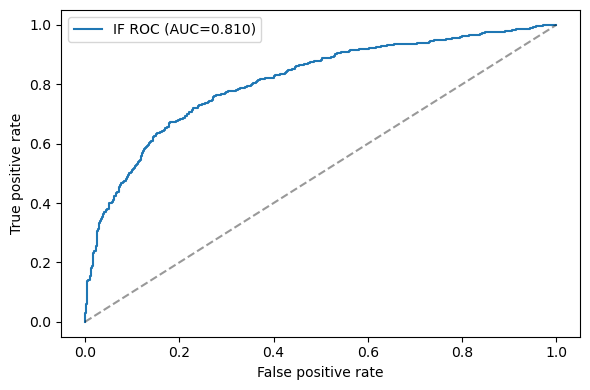

In [17]:
# ROC-like assessment for Isolation Forest
# ---------------------------------------------------------
# I generated an ROC using the IF decision_function (higher = more normal).
# Invert so that higher anomaly score = more anomalous -> use -IF_score
try:
    fpr, tpr, thresholds = roc_curve(y_true, -results["IF_score"].values)
    auc_if = roc_auc_score(y_true, -results["IF_score"].values)
    print("IsolationForest AUC:", auc_if)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'IF ROC (AUC={auc_if:.3f})')
    plt.plot([0,1],[0,1],'k--', alpha=0.4)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    plt.tight_layout()
except Exception as e:
    print("Could not compute ROC for IF:", e)


In [25]:
# ---------------------------------------------------------
print("SUMMARY:")
print(f"- Number of train samples: {len(X_train)}")
print(f"- Number of test  samples: {len(X_test)}")
print(f"- PCA components used: {n_components}")
print(f"- T2 threshold: {T2_threshold:.3f}")
print(f"- SPE threshold: {SPE_threshold:.3f}")
print(f"- IF threshold (1st pct of train): {if_threshold:.4f}")
print("")
print("Evaluation (combined alarm):")
print(f"  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
if lat_array.size > 0:
    print(f"  Detection latency (samples) mean: {lat_array.mean():.2f}, std: {lat_array.std():.2f}")
else:
    print("  No detections to report latency.")
print("")
print("Next suggestions:")
print("- Tune n_components and thresholds (alpha) to change sensitivity")
print("- Consider using moving-window features or time-embedding if temporal patterns matter")
print("- Add smoothing or debounce logic to reduce short false alarms")


SUMMARY:
- Number of train samples: 2000
- Number of test  samples: 1500
- PCA components used: 6
- T2 threshold: 16.812
- SPE threshold: 12.696
- IF threshold (1st pct of train): 0.0000

Evaluation (combined alarm):
  Precision: 0.9467  Recall: 0.7100  F1: 0.8114
  Detection latency (samples) mean: 2.00, std: 2.83

Next suggestions:
- Tune n_components and thresholds (alpha) to change sensitivity
- Consider using moving-window features or time-embedding if temporal patterns matter
- Add smoothing or debounce logic to reduce short false alarms
